# Call Center Scheduling

![](banner_pets.jpg)

Linear regression

In [1]:
f = "setup.R"; for (i in 1:10) { if (file.exists(f)) break else f = paste0("../", f) }; source(f)
update_geom_defaults("point", list(size=1))
options(warn=-1)

.................................................... start of document ....................................................

## Situation

A business process outsourcing company (BPO) is negotiating with a pet supply company (PSC) to provide customer service to the pet supply company's customers in 2015.  The contract calls for PSC to pay BPO per call handled (based on a reasonable rate and assuming PSC's call volume in 2015 will be about the same as it was in 2014).  Also, BPO will be charged a penalty for any unanswered calls beyond a certain threshold per day.  BPO will decide the appropriate daily staffing levels, but the daily staffing levels must be committed to in advance.  Note that BPO's profit will be dependent on a trade-off between saving staffing costs and incurring customer dissatisfaction penalties. 



### Objective
Build a linear regression model based on 2014 data to predict daily call volumes for 2015.  Then use the model to decide the appropriate daily staffing levels, and estimate profit.  Compare to fixed high staffing level and fixed low staffing level scenarios.

* **Role:** Vice President of Operations at a business process outsourcing company
* **Decision:** Call center agent staffing levels.
* **Approach:** Build and use a data analytic model to predict necessary staff levels and hire accordingly.
* **Dataset:** The dataset comprises daily call volumes and associated calendar and promotion information. 

## Decision Model

### Influence Diagram | Provider Perspective

<img src="business-model_pets_provider.jpg" align=left width=700 />

### Influence Diagram | Client Perspective

<img src="business-model_pets_client.jpg" align=left width=640 />

### Business Parameters

#### Budget

In [2]:
budget = 1000000 # $ per year
data.frame(budget)

budget
1000000


#### Contract Terms

In [3]:
call_payrate = 7 # $ paid per actual call answered, according to PSC
dissatisfaction_payrate = 25 # $ penalty per missed call over some threshold per day
threshold = 10 # permitted number of missed calls per day

data.frame(call_payrate, dissatisfaction_payrate, threshold)

call_payrate,dissatisfaction_payrate,threshold
7,25,10


#### Call Center

In [4]:
staff_payrate = 100 # $ per agent per day
handlerate = 30 # maximum number of calls per agent per day

data.frame(staff_payrate, handlerate)

staff_payrate,handlerate
100,30


## Data

### Retrieve Raw Data

In [5]:
data = read.csv("Pets.csv")
size(data)
data[1:6,]

observations,variables
711,14


Date,Day,WOM,Month,Year,Holidays,Promotions,Actual..Call.Volume..,Forecast..Call.Volume..using.original.System,X,X.1,X.2,X.3,X.4
1-Jan-14,Wednesday,1,Jan,2014,New Year's Day,"25% Off,FS on $49",373,NA,NA,NA,NA,NA,
2-Jan-14,Thursday,1,Jan,2014,Next Day of the-New Year's Day,No Email Drop,497,NA,NA,NA,NA,NA,
3-Jan-14,Friday,1,Jan,2014,,No Email Drop,467,NA,NA,NA,NA,NA,
4-Jan-14,Saturday,1,Jan,2014,,No Email Drop,430,NA,NA,NA,NA,NA,
5-Jan-14,Sunday,1,Jan,2014,,"25% Off,FS on $49",523,NA,NA,NA,NA,NA,
6-Jan-14,Monday,1,Jan,2014,,No Email Drop,617,NA,NA,NA,NA,NA,(using original system) (using new system)


### Clean Up Data

Discard comment columns.

In [6]:
data = data[,1:8]

Rename columns for convenience.

In [7]:
colnames(data) = tolower(colnames(data))
colnames(data)[8] = "volume"

Rename blank holiday variable value for convenience.

In [8]:
str(data)

'data.frame':	711 obs. of  8 variables:
 $ date      : Factor w/ 711 levels "1-Apr-14","1-Apr-15",..: 9 266 518 576 600 624 648 672 696 33 ...
 $ day       : Factor w/ 7 levels "Friday","Monday",..: 7 5 1 3 4 2 6 7 5 1 ...
 $ wom       : int  1 1 1 1 1 1 1 2 2 2 ...
 $ month     : Factor w/ 12 levels "Apr","Aug","Dec",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ year      : int  2014 2014 2014 2014 2014 2014 2014 2014 2014 2014 ...
 $ holidays  : Factor w/ 31 levels "","Christmas Day",..: 8 15 1 1 1 1 1 1 1 1 ...
 $ promotions: Factor w/ 117 levels "$10 Off Promo",..: 37 78 78 78 37 78 78 37 78 13 ...
 $ volume    : int  373 497 467 430 523 617 461 569 447 622 ...


In [9]:
levels(data$holidays)[1] = "none"
str(data$holidays)

 Factor w/ 31 levels "none","Christmas Day",..: 8 15 1 1 1 1 1 1 1 1 ...


Convert date from categorical (factor) to special date type so that order will be respected in plots. 

In [10]:
data$date = dmy(as.character(data$date))

Data is prepared.

In [11]:
size(data)
data[1:6,]

observations,variables
711,8


date,day,wom,month,year,holidays,promotions,volume
2014-01-01,Wednesday,1,Jan,2014,New Year's Day,"25% Off,FS on $49",373
2014-01-02,Thursday,1,Jan,2014,Next Day of the-New Year's Day,No Email Drop,497
2014-01-03,Friday,1,Jan,2014,none,No Email Drop,467
2014-01-04,Saturday,1,Jan,2014,none,No Email Drop,430
2014-01-05,Sunday,1,Jan,2014,none,"25% Off,FS on $49",523
2014-01-06,Monday,1,Jan,2014,none,No Email Drop,617


## Model A: Fixed Staffing Level is High

### Partition Data for Training & Testing

In [12]:
data.test = data[data$year==2015, c("date","volume")] # for testing

### Model

In [13]:
 volume.predicted = 500 # always predict 500 calls per day

### Predictions

In [14]:
data.test$volume.predicted = volume.predicted
data.test[1:6,]

,date,volume,volume.predicted
366,2015-01-01,300,500
367,2015-01-02,419,500
368,2015-01-03,340,500
369,2015-01-04,404,500
370,2015-01-05,389,500
371,2015-01-06,510,500


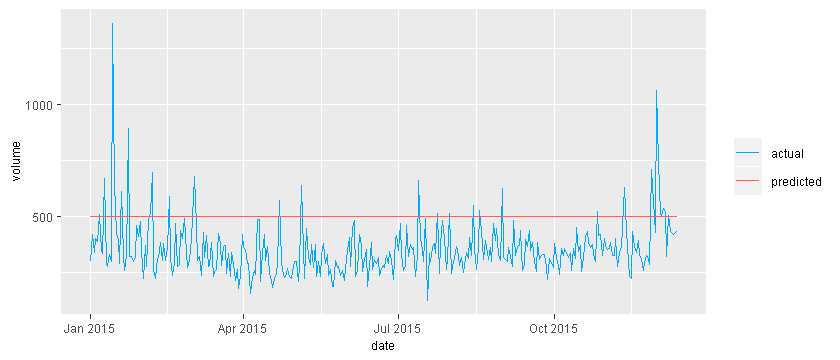

In [15]:
ggplot(data.test) +
geom_line(aes(x=date, y=volume, color="actual")) +
geom_line(aes(x=date, y=volume.predicted, color="predicted"))

In [16]:
data.test$volume.overstaffed = data.test$volume.predicted - data.test$volume
data.test$volume.overstaffed[data.test$volume.overstaffed < 0] = 0
data.test$overstaffed = data.test$volume.overstaffed >= 0

data.test$volume.understaffed = data.test$volume - data.test$volume.predicted
data.test$volume.understaffed[data.test$volume.understaffed < 0] = 0
data.test$understaffed = data.test$volume.understaffed > threshold

data.test[1:6,]

,date,volume,volume.predicted,volume.overstaffed,overstaffed,volume.understaffed,understaffed
366,2015-01-01,300,500,200,TRUE,0,FALSE
367,2015-01-02,419,500,81,TRUE,0,FALSE
368,2015-01-03,340,500,160,TRUE,0,FALSE
369,2015-01-04,404,500,96,TRUE,0,FALSE
370,2015-01-05,389,500,111,TRUE,0,FALSE
371,2015-01-06,510,500,0,TRUE,10,FALSE


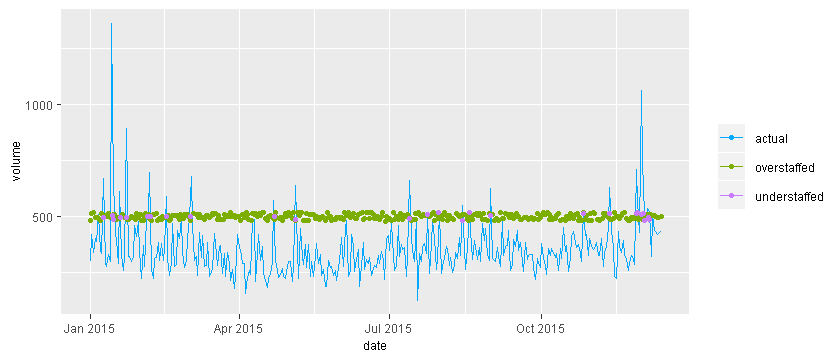

In [17]:
ggplot(data.test) +
geom_line(aes(x=date, y=volume, color="actual")) +
geom_jitter(aes(x=date, y=volume.predicted, color="overstaffed"), data=data.test[data.test$overstaffed,], height=20) +
geom_jitter(aes(x=date, y=volume.predicted, color="understaffed"), data=data.test[data.test$understaffed,], height=20) +
scale_color_manual(values=c(actual=PALETTE[1], overstaffed=PALETTE[3], understaffed=PALETTE[4])) # + ylab("volume")

### Business Result

#### Call Center Perspective

In [18]:
revenue = call_payrate * (sum(data.test$volume[data.test$overstaffed]) +
                          sum(data.test$volume.predicted[data.test$understaffed]))
          
staff_cost = (staff_payrate/handlerate) * sum(data.test$volume.predicted)

dissatisfaction_cost = dissatisfaction_payrate * sum(data.test$volume.understaffed[data.test$understaffed])

cost = staff_cost + dissatisfaction_cost
profit = revenue - cost
business_value.hf.cc = data.frame(model="Fixed Staffing Rate is High", revenue, staff_cost, dissatisfaction_cost, cost, profit)

business_value.hf.cc

model,revenue,staff_cost,dissatisfaction_cost,cost,profit
Fixed Staffing Rate is High,947807,576666.7,102125,678791.7,269015.3


#### Client Perspective

In [19]:
call_cost = call_payrate * (sum(data.test$volume[data.test$overstaffed]) +
                            sum(data.test$volume.predicted[data.test$understaffed]))

dissatisfaction_credit = dissatisfaction_payrate * sum(data.test$volume.understaffed[data.test$understaffed])

cost = call_cost - dissatisfaction_credit
savings = budget - cost

csat = 1 - (sum(data.test$volume.understaffed) / sum(data.test$volume))

business_value.hf.client = data.frame(model="Fixed Staffing Rate is High", call_cost, dissatisfaction_credit, cost, savings, csat)

business_value.hf.client

model,call_cost,dissatisfaction_credit,cost,savings,csat
Fixed Staffing Rate is High,947807,102125,845682,154318,0.9664709


## Model B: Fixed Staffing Level is Low

### Partition Data for Training & Testing

In [20]:
data.test = data[data$year==2015, c("date","volume")] # for testing

### Model

In [21]:
 volume.predicted = 350 # always predict 350 calls

### Predictions

In [22]:
data.test$volume.predicted = volume.predicted
data.test[1:6,]

,date,volume,volume.predicted
366,2015-01-01,300,350
367,2015-01-02,419,350
368,2015-01-03,340,350
369,2015-01-04,404,350
370,2015-01-05,389,350
371,2015-01-06,510,350


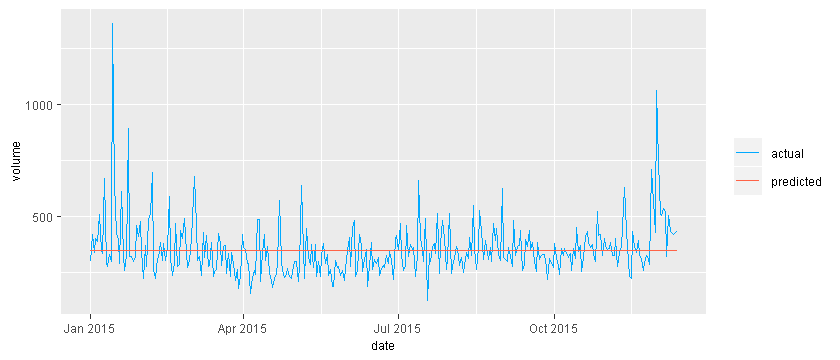

In [23]:
ggplot(data.test) +
geom_line(aes(x=date, y=volume, color="actual")) +
geom_line(aes(x=date, y=volume.predicted, color="predicted"))

In [24]:
data.test$volume.overstaffed = data.test$volume.predicted - data.test$volume
data.test$volume.overstaffed[data.test$volume.overstaffed < 0] = 0
data.test$overstaffed = data.test$volume.overstaffed >= 0

data.test$volume.understaffed = data.test$volume - data.test$volume.predicted
data.test$volume.understaffed[data.test$volume.understaffed < 0] = 0
data.test$understaffed = data.test$volume.understaffed > threshold

data.test[1:6,]

,date,volume,volume.predicted,volume.overstaffed,overstaffed,volume.understaffed,understaffed
366,2015-01-01,300,350,50,TRUE,0,FALSE
367,2015-01-02,419,350,0,TRUE,69,TRUE
368,2015-01-03,340,350,10,TRUE,0,FALSE
369,2015-01-04,404,350,0,TRUE,54,TRUE
370,2015-01-05,389,350,0,TRUE,39,TRUE
371,2015-01-06,510,350,0,TRUE,160,TRUE


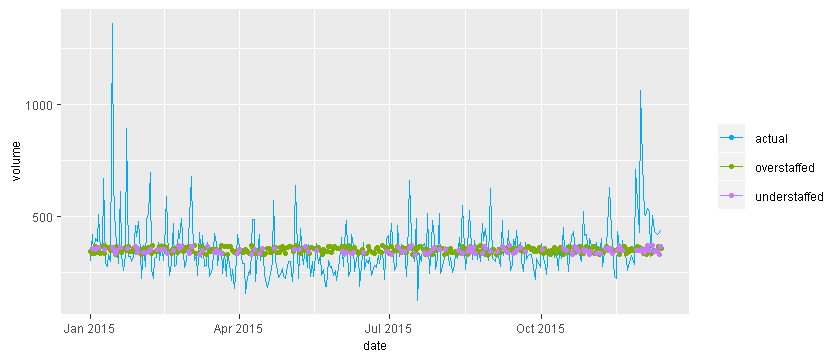

In [25]:
ggplot(data.test) +
geom_line(aes(x=date, y=volume, color="actual")) +
geom_jitter(aes(x=date, y=volume.predicted, color="overstaffed"), data=data.test[data.test$overstaffed,], height=20) +
geom_jitter(aes(x=date, y=volume.predicted, color="understaffed"), data=data.test[data.test$understaffed,], height=20) +
scale_color_manual(values=c(actual=PALETTE[1], overstaffed=PALETTE[3], understaffed=PALETTE[4]))

### Business Result

#### Call Center Perspective

In [26]:
revenue = call_payrate * (sum(data.test$volume[data.test$overstaffed]) +
                          sum(data.test$volume.predicted[data.test$understaffed]))
          
staff_cost = (staff_payrate/handlerate) * sum(data.test$volume.predicted)

dissatisfaction_cost = dissatisfaction_payrate * sum(data.test$volume.understaffed[data.test$understaffed])

cost = staff_cost + dissatisfaction_cost
profit = revenue - cost
business_value.lf.cc = data.frame(model="Fixed Staffing Rate is Low", revenue, staff_cost, dissatisfaction_cost, cost, profit)

business_value.lf.cc

model,revenue,staff_cost,dissatisfaction_cost,cost,profit
Fixed Staffing Rate is Low,1175307,403666.7,366100,769766.7,405540.3


#### Client Perspective

In [27]:
call_cost = call_payrate * (sum(data.test$volume[data.test$overstaffed]) +
                            sum(data.test$volume.predicted[data.test$understaffed]))

dissatisfaction_credit = dissatisfaction_payrate * sum(data.test$volume.understaffed[data.test$understaffed])

cost = call_cost - dissatisfaction_credit
savings = budget - cost

csat = 1 - (sum(data.test$volume.understaffed) / sum(data.test$volume))

business_value.lf.client = data.frame(model="Fixed Staffing Rate is Low", call_cost, dissatisfaction_credit, cost, savings, csat)

business_value.lf.client

model,call_cost,dissatisfaction_credit,cost,savings,csat
Fixed Staffing Rate is Low,1175307,366100,809207,190793,0.8797232


## Model C: Linear Regression


### Categorical Variables to Dummy Variables

In [28]:
data.d = dummify(data)
data.d$dayMonday = NULL
data.d$monthJan = NULL
data.d$holidaysnone = NULL
data.d$"PromotionsNo Email Drop" = NULL
size(data.d)
data.d[1:6,]

observations,variables
711,168


date,dayFriday,daySaturday,daySunday,dayThursday,dayTuesday,dayWednesday,wom,monthApr,monthAug,monthDec,monthFeb,monthJul,monthJun,monthMar,monthMay,monthNov,monthOct,monthSep,year,holidaysChristmas Day,holidaysColumbus Day,holidaysIndependence Day,holidaysLabor Day,holidaysMartin Luther King Jr. Day,holidaysMemorial Day,holidaysNew Year's Day,holidaysNext Day of the-Christmas Day,holidaysNext Day of the-Columbus Day,holidaysNext Day of the-Independence Day,holidaysNext Day of the-Labor Day,holidaysNext Day of the-Martin Luther King Jr. Day,holidaysNext Day of the-Memorial Day,holidaysNext Day of the-New Year's Day,holidaysNext Day of the-President's Day,holidaysNext Day of the-Thanksgiving Day,holidaysNext Day of the-Veteran's Day,...,promotionsRD Event,"promotionsRD Event, Earn $20","promotionsRD Event,20% Off on Food,FS on $49","promotionsRD Event,Double Points","promotionsRD Event,Up To 15% Off,FS on $49","promotionsReveal Your Deal Promo,$10, $20, $30 Off,FS on $49","promotionsReveal Your Deal Promo,15, 20% Off","promotionsReveal Your Deal Promo,15, 20% Off,","promotionsReveal Your Deal Promo,15, 20, 30% Off,","promotionsReveal Your Deal Promo,20, 25, 30% Off,FS on $75","promotionsReveal Your Deal, $10, $15, $20 Off",promotionsThanks Giving,promotionsThanksgiving,promotionsTiered Promo,promotionsTreat Thursday,"promotionsTreat Thursday,$10 Off,","promotionsTreat Thursday,$5 Off,FS on $35","promotionsTreat Thursday,$5 Off,FS on $49","promotionsTreat Thursday,12 Items,FS on $49","promotionsTreat Thursday,12 Treats,FS on $49","promotionsTreat Thursday,30-50% Off,FS on $49","promotionsTreat Thursday,Buy $25 get $5 eGC ,","promotionsTreat Thursday,Double Points,Up to 40% Off,FS on $49","promotionsTreat Thursday,FS on $49","promotionsTreat Thursday,Up To 30% Off on Toys,FS on $49","promotionsTreat Thursday,Up to 50% on Select Items,20% Off,FS on $49","promotionsUp To 15% Off,FS on $49","promotionsUp To 20% Off,FS on $49","promotionsUp To 25% Off, FS on $49","promotionsUp To 25% Off,FS on $49","promotionsUp To 35% Off,FS on $49","promotionsUp To 40% Off plus $5 FS on $10, FS on $49","promotionsUp To 40% Off,FS on $49","promotionsUp To 50% Off,FS on $49",promotionsUpto 75% offer,"promotionsValentine's Day,25% Off on Supplies,FS on $49",volume
2014-01-01,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,373
2014-01-02,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,497
2014-01-03,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,467
2014-01-04,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,430
2014-01-05,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,523
2014-01-06,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,617


### Partition Data for Training & Testing

In [29]:
data.train = data.d[data.d$year==2014,] # to build model
data.test  = data.d[data.d$year==2015,] # to test model predictions

### Model

In [30]:
model = lm(volume ~ ., data.train[,-1]) # model will predict volume given all other variables except date
data.frame(model$coefficients)

,model.coefficients
(Intercept),686.410216
dayFriday,-75.886818
daySaturday,-114.474064
daySunday,-121.454166
dayThursday,-107.771273
dayTuesday,-14.471350
dayWednesday,-46.728440
wom,-6.780597
monthApr,-81.093910
monthAug,-153.521260


### Predictions

In [31]:
hide = 2:167
data.test$volume.predicted = predict(model, data.test[,-1])
data.test[1:6, -hide]

,date,volume,volume.predicted
366,2015-01-01,300,317.0254
367,2015-01-02,419,689.4385
368,2015-01-03,340,565.1556
369,2015-01-04,404,558.1755
370,2015-01-05,389,674.5614
371,2015-01-06,510,696.8772


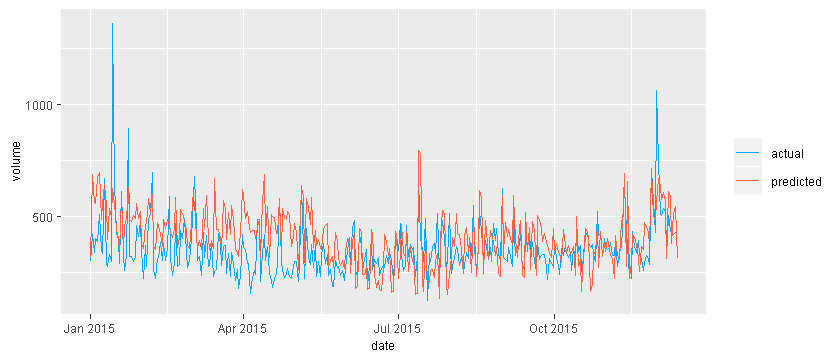

In [32]:
ggplot(data.test) +
geom_line(aes(x=date, y=volume, color="actual")) +
geom_line(aes(x=date, y=volume.predicted, color="predicted")) + 
ylab("volume")

In [33]:
data.test$volume.overstaffed = data.test$volume.predicted - data.test$volume
data.test$volume.overstaffed[data.test$volume.overstaffed < 0] = 0
data.test$overstaffed = data.test$volume.overstaffed >= 0

data.test$volume.understaffed = data.test$volume - data.test$volume.predicted
data.test$volume.understaffed[data.test$volume.understaffed < 0] = 0
data.test$understaffed = data.test$volume.understaffed > threshold

data.test[1:6, -hide]

,date,volume,volume.predicted,volume.overstaffed,overstaffed,volume.understaffed,understaffed
366,2015-01-01,300,317.0254,17.0254,TRUE,0,FALSE
367,2015-01-02,419,689.4385,270.4385,TRUE,0,FALSE
368,2015-01-03,340,565.1556,225.1556,TRUE,0,FALSE
369,2015-01-04,404,558.1755,154.1755,TRUE,0,FALSE
370,2015-01-05,389,674.5614,285.5614,TRUE,0,FALSE
371,2015-01-06,510,696.8772,186.8772,TRUE,0,FALSE


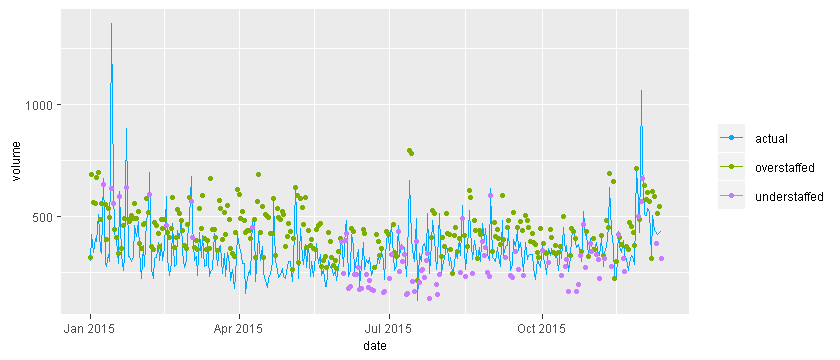

In [34]:
ggplot(data.test) +
geom_line(aes(x=date, y=volume, color="actual")) +
geom_point(aes(x=date, y=volume.predicted, color="overstaffed"), data=data.test[data.test$overstaffed,]) +
geom_point(aes(x=date, y=volume.predicted, color="understaffed"), data=data.test[data.test$understaffed,]) +
scale_color_manual(values=c(actual=PALETTE[1], overstaffed=PALETTE[3], understaffed=PALETTE[4]))

### Business Result

#### Call Center Perspective

In [35]:
revenue = call_payrate * (sum(data.test$volume[data.test$overstaffed]) +
                          sum(data.test$volume.predicted[data.test$understaffed]))

staff_cost = (staff_payrate/handlerate) * sum(data.test$volume.predicted)

dissatisfaction_cost = dissatisfaction_payrate * sum(data.test$volume.understaffed[data.test$understaffed])

cost = staff_cost + dissatisfaction_cost
profit = revenue - cost
business_value.lr.cc = data.frame(model="Linear Regression", revenue, staff_cost, dissatisfaction_cost, cost, profit)

business_value.lr.cc

model,revenue,staff_cost,dissatisfaction_cost,cost,profit
Linear Regression,1060117,471982,208692.4,680674.4,379442.8


#### Client Perspective

In [36]:
call_cost = call_payrate * (sum(data.test$volume[data.test$overstaffed]) +
                            sum(data.test$volume.predicted[data.test$understaffed]))

dissatisfaction_credit = dissatisfaction_payrate * sum(data.test$volume.understaffed[data.test$understaffed])

cost = call_cost - dissatisfaction_credit
savings = budget - cost

csat = 1 - (sum(data.test$volume.understaffed) / sum(data.test$volume))

business_value.lr.client = data.frame(model="Linear Regression", call_cost, dissatisfaction_credit, cost, savings, csat)

business_value.lr.client

model,call_cost,dissatisfaction_credit,cost,savings,csat
Linear Regression,1060117,208692.4,851424.8,148575.2,0.9312927


## Model D:  Linear Regression with Staffing Buffer

In [37]:
buffer = 50
fmt(buffer)

buffer
50


In [38]:
hide = 2:167
data.test$volume.predicted = buffer+predict(model, data.test[,-1])
data.test[1:6, -hide][,1:3]

,date,volume,volume.predicted
366,2015-01-01,300,367.0254
367,2015-01-02,419,739.4385
368,2015-01-03,340,615.1556
369,2015-01-04,404,608.1755
370,2015-01-05,389,724.5614
371,2015-01-06,510,746.8772


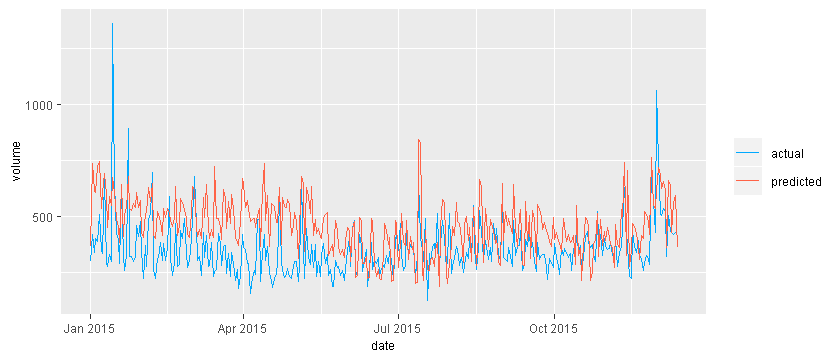

In [39]:
ggplot(data.test) +
geom_line(aes(x=date, y=volume, color="actual")) +
geom_line(aes(x=date, y=volume.predicted, color="predicted"))

In [40]:
data.test$volume.overstaffed = data.test$volume.predicted - data.test$volume
data.test$volume.overstaffed[data.test$volume.overstaffed < 0] = 0
data.test$overstaffed = data.test$volume.overstaffed >= 0

data.test$volume.understaffed = data.test$volume - data.test$volume.predicted
data.test$volume.understaffed[data.test$volume.understaffed < 0] = 0
data.test$understaffed = data.test$volume.understaffed > threshold

data.test[1:6, -hide]

,date,volume,volume.predicted,volume.overstaffed,overstaffed,volume.understaffed,understaffed
366,2015-01-01,300,367.0254,67.0254,TRUE,0,FALSE
367,2015-01-02,419,739.4385,320.4385,TRUE,0,FALSE
368,2015-01-03,340,615.1556,275.1556,TRUE,0,FALSE
369,2015-01-04,404,608.1755,204.1755,TRUE,0,FALSE
370,2015-01-05,389,724.5614,335.5614,TRUE,0,FALSE
371,2015-01-06,510,746.8772,236.8772,TRUE,0,FALSE


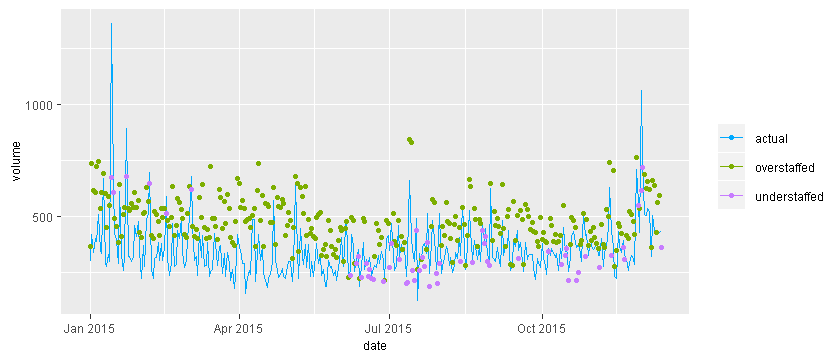

In [41]:
ggplot(data.test) +
geom_line(aes(x=date, y=volume, color="actual")) +
geom_point(aes(x=date, y=volume.predicted, color="overstaffed"), data=data.test[data.test$overstaffed,]) +
geom_point(aes(x=date, y=volume.predicted, color="understaffed"), data=data.test[data.test$understaffed,]) +
scale_color_manual(values=c(actual=PALETTE[1], overstaffed=PALETTE[3], understaffed=PALETTE[4]))

### Business Result

#### Call Center Perspective

In [42]:
revenue = call_payrate * (sum(data.test$volume[data.test$overstaffed]) +
                          sum(data.test$volume.predicted[data.test$understaffed]))

staff_cost = (staff_payrate/handlerate) * sum(data.test$volume.predicted)

dissatisfaction_cost = dissatisfaction_payrate * sum(data.test$volume.understaffed[data.test$understaffed])

cost = staff_cost + dissatisfaction_cost
profit = revenue - cost
business_value.lrb.cc = data.frame(model="Linear Regression + Buffer", revenue, staff_cost, dissatisfaction_cost, cost, profit)

business_value.lrb.cc

model,revenue,staff_cost,dissatisfaction_cost,cost,profit
Linear Regression + Buffer,991559.2,529648.7,107967,637615.6,353943.6


#### Client Perspective

In [43]:
call_cost = call_payrate * (sum(data.test$volume[data.test$overstaffed]) +
                            sum(data.test$volume.predicted[data.test$understaffed]))

dissatisfaction_credit = dissatisfaction_payrate * sum(data.test$volume.understaffed[data.test$understaffed])

cost = call_cost - dissatisfaction_credit
savings = budget - cost

csat = 1 - (sum(data.test$volume.understaffed) / sum(data.test$volume))

business_value.lrb.client = data.frame(model="Linear Regression + Buffer", call_cost, dissatisfaction_credit, cost, savings, csat)

business_value.lrb.client

model,call_cost,dissatisfaction_credit,cost,savings,csat
Linear Regression + Buffer,991559.2,107967,883592.3,116407.7,0.9642675


## Model E: Piece-wise Linear Regression

### Synthetic Variable for Halfyear 

In [44]:
data.dh = data.d
data.dh$halfyear = factor(month(data.dh$date) <= 6, levels=c(TRUE,FALSE), labels=c("1st_half","2nd_half"))
data.dh = front(data.dh)
data.dh[1:6,]

halfyear,date,dayFriday,daySaturday,daySunday,dayThursday,dayTuesday,dayWednesday,wom,monthApr,monthAug,monthDec,monthFeb,monthJul,monthJun,monthMar,monthMay,monthNov,monthOct,monthSep,year,holidaysChristmas Day,holidaysColumbus Day,holidaysIndependence Day,holidaysLabor Day,holidaysMartin Luther King Jr. Day,holidaysMemorial Day,holidaysNew Year's Day,holidaysNext Day of the-Christmas Day,holidaysNext Day of the-Columbus Day,holidaysNext Day of the-Independence Day,holidaysNext Day of the-Labor Day,holidaysNext Day of the-Martin Luther King Jr. Day,holidaysNext Day of the-Memorial Day,holidaysNext Day of the-New Year's Day,holidaysNext Day of the-President's Day,holidaysNext Day of the-Thanksgiving Day,...,promotionsRD Event,"promotionsRD Event, Earn $20","promotionsRD Event,20% Off on Food,FS on $49","promotionsRD Event,Double Points","promotionsRD Event,Up To 15% Off,FS on $49","promotionsReveal Your Deal Promo,$10, $20, $30 Off,FS on $49","promotionsReveal Your Deal Promo,15, 20% Off","promotionsReveal Your Deal Promo,15, 20% Off,","promotionsReveal Your Deal Promo,15, 20, 30% Off,","promotionsReveal Your Deal Promo,20, 25, 30% Off,FS on $75","promotionsReveal Your Deal, $10, $15, $20 Off",promotionsThanks Giving,promotionsThanksgiving,promotionsTiered Promo,promotionsTreat Thursday,"promotionsTreat Thursday,$10 Off,","promotionsTreat Thursday,$5 Off,FS on $35","promotionsTreat Thursday,$5 Off,FS on $49","promotionsTreat Thursday,12 Items,FS on $49","promotionsTreat Thursday,12 Treats,FS on $49","promotionsTreat Thursday,30-50% Off,FS on $49","promotionsTreat Thursday,Buy $25 get $5 eGC ,","promotionsTreat Thursday,Double Points,Up to 40% Off,FS on $49","promotionsTreat Thursday,FS on $49","promotionsTreat Thursday,Up To 30% Off on Toys,FS on $49","promotionsTreat Thursday,Up to 50% on Select Items,20% Off,FS on $49","promotionsUp To 15% Off,FS on $49","promotionsUp To 20% Off,FS on $49","promotionsUp To 25% Off, FS on $49","promotionsUp To 25% Off,FS on $49","promotionsUp To 35% Off,FS on $49","promotionsUp To 40% Off plus $5 FS on $10, FS on $49","promotionsUp To 40% Off,FS on $49","promotionsUp To 50% Off,FS on $49",promotionsUpto 75% offer,"promotionsValentine's Day,25% Off on Supplies,FS on $49",volume
1st_half,2014-01-01,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,373
1st_half,2014-01-02,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,497
1st_half,2014-01-03,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,467
1st_half,2014-01-04,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,430
1st_half,2014-01-05,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,523
1st_half,2014-01-06,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,617


### Partition Data for Training & Testing

In [45]:
data.train = data.dh[data.dh$year==2014,] # to build model
data.test = data.dh[data.dh$year==2015,] # to test model predictions

data.train.1st_half = data.train[data.train$halfyear=="1st_half",]
data.train.2nd_half = data.train[data.train$halfyear=="2nd_half",]
data.test.1st_half = data.test[data.test$halfyear=="1st_half",]
data.test.2nd_half = data.test[data.test$halfyear=="2nd_half",]

### Models

In [46]:
model.1st_half = lm(volume ~ ., data.train.1st_half[,-(1:2)]) # model will predict volume given all other variables except date and halfyear
data.frame(model.1st_half$coefficients)

,model.1st_half.coefficients
(Intercept),697.125228
dayFriday,-73.284860
daySaturday,-120.221542
daySunday,-98.691332
dayThursday,-128.620443
dayTuesday,17.778968
dayWednesday,-37.933546
wom,-11.216109
monthApr,-87.963918
monthAug,NA


In [47]:
model.2nd_half = lm(volume ~ ., data.train.2nd_half[,-(1:2)]) # model will predict volume given all other variables except date and halfyear
data.frame(model.2nd_half$coefficients)

,model.2nd_half.coefficients
(Intercept),431.2383465
dayFriday,-68.6023025
daySaturday,-105.1864759
daySunday,-144.3789517
dayThursday,-94.6458951
dayTuesday,-66.9812371
dayWednesday,-57.5571038
wom,0.7428355
monthApr,NA
monthAug,0.4317190


### Predictions

In [48]:
hide = 3:168

data.test.1st_half$volume.predicted = predict(model.1st_half, data.test.1st_half[,-(1:2)])
data.test.2nd_half$volume.predicted = predict(model.2nd_half, data.test.2nd_half[,-(1:2)])
data.test = rbind(data.test.1st_half, data.test.2nd_half)

data.test[1:6, -hide]

,halfyear,date,volume,volume.predicted
366,1st_half,2015-01-01,300,278.5628
367,1st_half,2015-01-02,419,725.5421
368,1st_half,2015-01-03,340,565.6876
369,1st_half,2015-01-04,404,587.2178
370,1st_half,2015-01-05,389,689.6594
371,1st_half,2015-01-06,510,731.6926


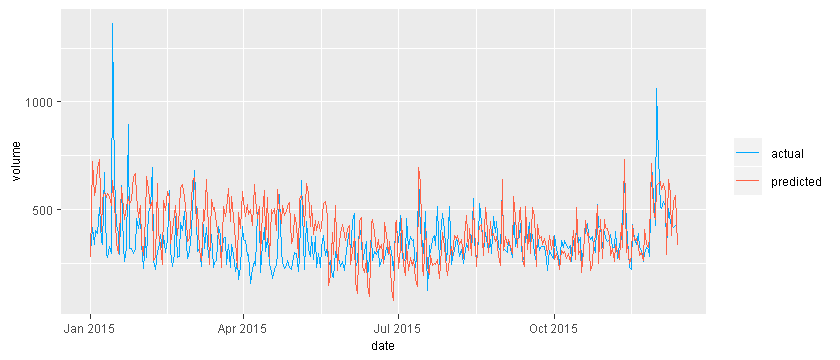

In [49]:
ggplot(data.test) +
geom_line(aes(x=date, y=volume, color="actual")) +
geom_line(aes(x=date, y=volume.predicted, color="predicted"))

In [50]:
data.test$volume.overstaffed = data.test$volume.predicted - data.test$volume
data.test$volume.overstaffed[data.test$volume.overstaffed < 0] = 0
data.test$overstaffed = data.test$volume.overstaffed >= 0

data.test$volume.understaffed = data.test$volume - data.test$volume.predicted
data.test$volume.understaffed[data.test$volume.understaffed < 0] = 0
data.test$understaffed = data.test$volume.understaffed > threshold

data.test[1:6, -hide]

,halfyear,date,volume,volume.predicted,volume.overstaffed,overstaffed,volume.understaffed,understaffed
366,1st_half,2015-01-01,300,278.5628,0.0000,TRUE,21.43718,TRUE
367,1st_half,2015-01-02,419,725.5421,306.5421,TRUE,0.00000,FALSE
368,1st_half,2015-01-03,340,565.6876,225.6876,TRUE,0.00000,FALSE
369,1st_half,2015-01-04,404,587.2178,183.2178,TRUE,0.00000,FALSE
370,1st_half,2015-01-05,389,689.6594,300.6594,TRUE,0.00000,FALSE
371,1st_half,2015-01-06,510,731.6926,221.6926,TRUE,0.00000,FALSE


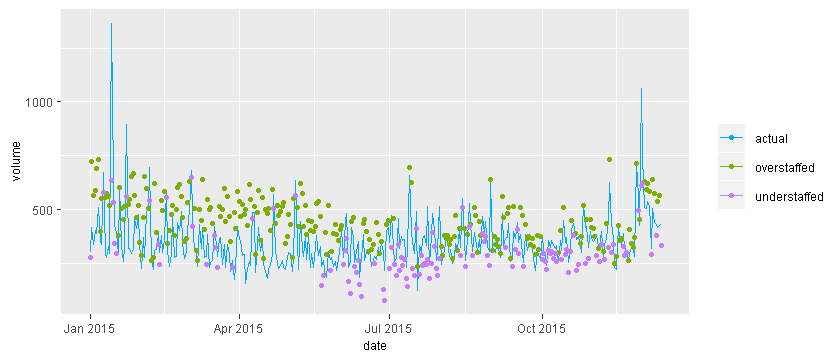

In [51]:
ggplot(data.test) +
geom_line(aes(x=date, y=volume, color="actual")) +
geom_point(aes(x=date, y=volume.predicted, color="overstaffed"), data=data.test[data.test$overstaffed,]) +
geom_point(aes(x=date, y=volume.predicted, color="understaffed"), data=data.test[data.test$understaffed,]) +
scale_color_manual(values=c(actual=PALETTE[1], overstaffed=PALETTE[3], understaffed=PALETTE[4]))

### Business Result

#### Call Center Perspective

In [52]:
revenue = call_payrate * (sum(data.test$volume[data.test$overstaffed]) +
                          sum(data.test$volume.predicted[data.test$understaffed]))

staff_cost = (staff_payrate/handlerate) * sum(data.test$volume.predicted)

dissatisfaction_cost = dissatisfaction_payrate * sum(data.test$volume.understaffed[data.test$understaffed])

cost = staff_cost + dissatisfaction_cost
profit = revenue - cost
business_value.plr.cc = data.frame(model="Piece-wise Linear Regression", revenue, staff_cost, dissatisfaction_cost, cost, profit)

business_value.plr.cc

model,revenue,staff_cost,dissatisfaction_cost,cost,profit
Piece-wise Linear Regression,1104974,465671.5,253215.9,718887.4,386086.1


#### Client Perspective

In [53]:
call_cost = call_payrate * (sum(data.test$volume[data.test$overstaffed]) +
                            sum(data.test$volume.predicted[data.test$understaffed]))

dissatisfaction_credit = dissatisfaction_payrate * sum(data.test$volume.understaffed[data.test$understaffed])

cost = call_cost - dissatisfaction_credit
savings = budget - cost

csat = 1 - (sum(data.test$volume.understaffed) / sum(data.test$volume))

business_value.plr.client = data.frame(model="Piece-wise Linear Regression", call_cost, dissatisfaction_credit, cost, savings, csat)

business_value.plr.client

model,call_cost,dissatisfaction_credit,cost,savings,csat
Piece-wise Linear Regression,1104974,253215.9,851757.6,148242.4,0.9166433


## Comparative Analysis

### Call Center Perspective

In [54]:
business_value.cc = rbind(business_value.hf.cc,
                          business_value.lf.cc,
                          business_value.lr.cc,
                          business_value.lrb.cc,
                          business_value.plr.cc)
business_value.cc

model,revenue,staff_cost,dissatisfaction_cost,cost,profit
Fixed Staffing Rate is High,947807.0,576666.7,102125.0,678791.7,269015.3
Fixed Staffing Rate is Low,1175307.0,403666.7,366100.0,769766.7,405540.3
Linear Regression,1060117.1,471982.0,208692.4,680674.4,379442.8
Linear Regression + Buffer,991559.2,529648.7,107967.0,637615.6,353943.6
Piece-wise Linear Regression,1104973.5,465671.5,253215.9,718887.4,386086.1


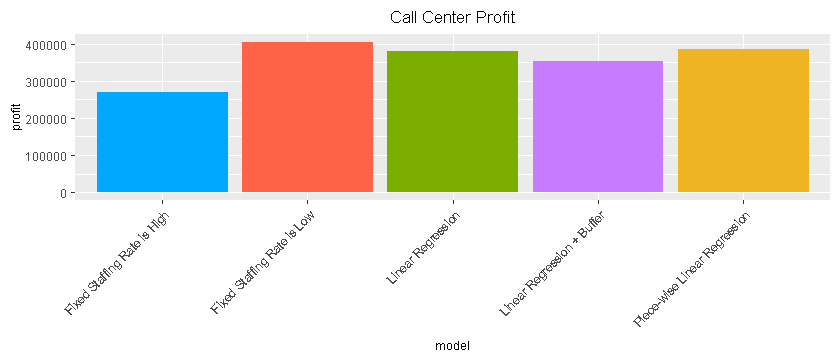

In [55]:
ggplot(business_value.cc) + ggtitle("Call Center Profit") +
geom_col(aes(x=model, y=profit, fill=model)) + theme.x_axis_45 + theme.no_legend

### Client Perspective

In [56]:
business_value.client = rbind(business_value.hf.client,
                              business_value.lf.client,
                              business_value.lr.client,
                              business_value.lrb.client,
                              business_value.plr.client)
business_value.client

model,call_cost,dissatisfaction_credit,cost,savings,csat
Fixed Staffing Rate is High,947807.0,102125.0,845682.0,154318.0,0.9664709
Fixed Staffing Rate is Low,1175307.0,366100.0,809207.0,190793.0,0.8797232
Linear Regression,1060117.1,208692.4,851424.8,148575.2,0.9312927
Linear Regression + Buffer,991559.2,107967.0,883592.3,116407.7,0.9642675
Piece-wise Linear Regression,1104973.5,253215.9,851757.6,148242.4,0.9166433


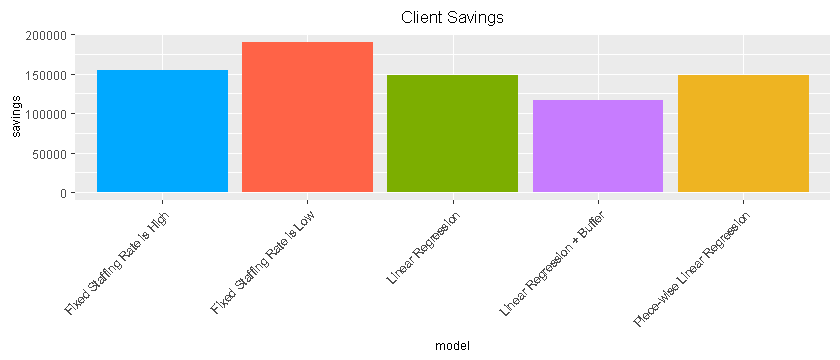

In [57]:
ggplot(business_value.client) + ggtitle("Client Savings") +
geom_col(aes(x=model, y=savings, fill=model)) +
theme.x_axis_45 + theme.no_legend

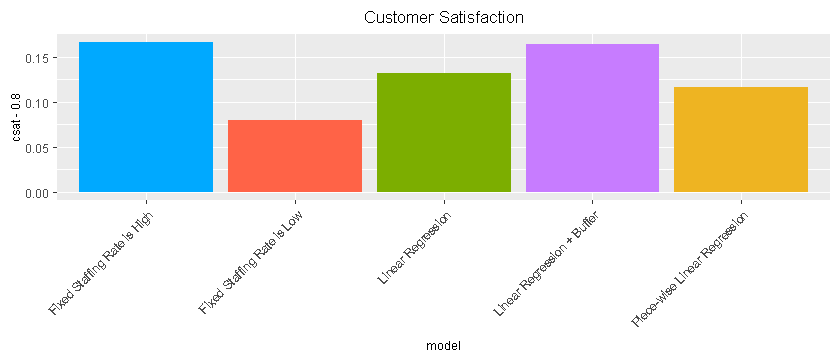

In [58]:
ggplot(business_value.client) + ggtitle("Customer Satisfaction") +
geom_col(aes(x=model, y=csat-0.80, fill=model)) + 
theme.x_axis_45 + theme.no_legend

### Partnership Perspective

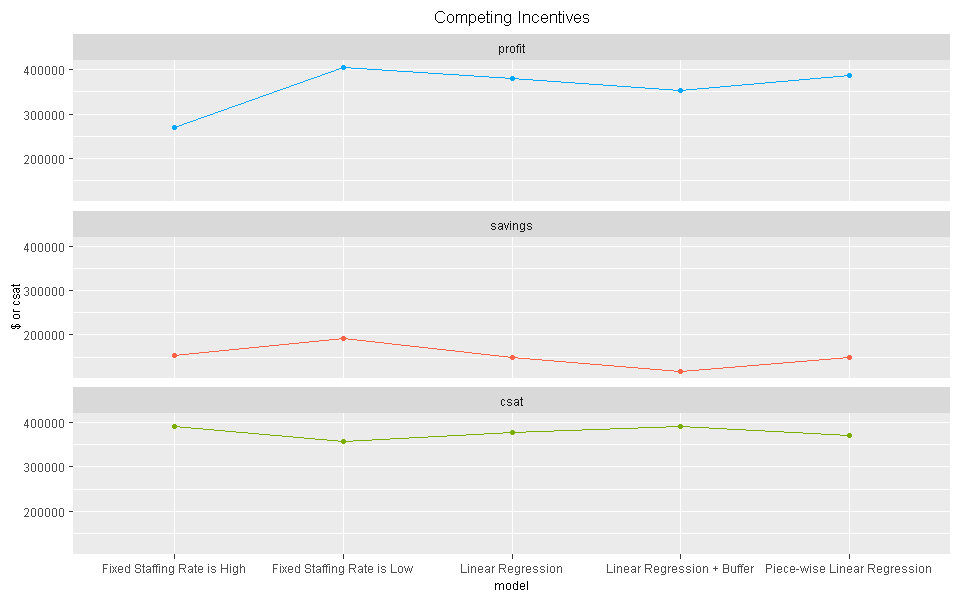

In [59]:
business_value = merge(business_value.cc[,c(1,6)], business_value.client[,c(1,5,6)])
business_value$csat = business_value$csat * max(business_value$profit)
business_value.long = melt(business_value, id="model")

output_size(8, 5)
ggplot(business_value.long) + ggtitle("Competing Incentives") +
geom_line(aes(x=model, y=value, group=variable, color=variable)) + 
geom_point(aes(x=model, y=value, group=variable, color=variable)) + 
facet_wrap(~variable, nrow=3) +
ylab("$ or csat") + theme.no_legend

## Discussion

* How are incentives for call center and client aligned/misaligned?
* How are client goals for savings and customer satisfaction aligned/misaligned?
* How could you improve the model?
* How could you improve the contract?

<font size=1;>
<p style="text-align: left;">
Copyright (c) Berkeley Data Analytics Group, LLC
<span style="float: right;">
Document revised April 20, 2020
</span>
</p>
</font>